In [1]:
# ============================================================
# Cell 2: Imports + reproducibility settings
# ============================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# ---- Fix random seeds for reproducibility (important for marking) ----
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# ---- Select device: use GPU if available ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# ============================================================
# Cell 3: Load labeled_data.csv and inspect schema
# ============================================================
DATA_PATH = "labeled_data.csv"  # <- your uploaded file

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())


Dataset shape: (24783, 7)


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...



Columns: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet']


In [3]:
# ============================================================
# Cell 4: Clean dataset and define binary classification labels
# ============================================================
# This dataset is commonly structured as:
# text column: "tweet" (sometimes "text")
# label column: "class"
#
# Typical meaning in this Kaggle dataset:
# class = 0 (hate speech), 1 (offensive), 2 (neither)
#
# We convert to binary (recommended for clarity + strong report):
# y = 1 if (hate OR offensive), else 0

# --- Robustly find text column ---
text_candidates = ["tweet", "text", "content"]
label_candidates = ["class", "label", "target"]

text_col = next((c for c in text_candidates if c in df.columns), None)
label_col = next((c for c in label_candidates if c in df.columns), None)

if text_col is None:
    raise ValueError(f"Could not find text column. Tried: {text_candidates}")
if label_col is None:
    raise ValueError(f"Could not find label column. Tried: {label_candidates}")

print(f"Using text column: {text_col}")
print(f"Using label column: {label_col}")

# Keep only what we need (clean experiment, avoids leakage)
df = df[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label_raw"})

# Drop missing data and enforce types
df.dropna(subset=["text", "label_raw"], inplace=True)
df["text"] = df["text"].astype(str)
df["label_raw"] = df["label_raw"].astype(int)

# --- Binary mapping ---
# 1 = hateful/offensive (class 0 or 1)
# 0 = neither (class 2)
df["label"] = df["label_raw"].apply(lambda x: 1 if x in [0, 1] else 0)

print("\nRaw label distribution (original classes):")
print(df["label_raw"].value_counts())

print("\nBinary label distribution (0=clean, 1=hate/offensive):")
print(df["label"].value_counts())


Using text column: tweet
Using label column: class

Raw label distribution (original classes):
label_raw
1    19190
2     4163
0     1430
Name: count, dtype: int64

Binary label distribution (0=clean, 1=hate/offensive):
label
1    20620
0     4163
Name: count, dtype: int64


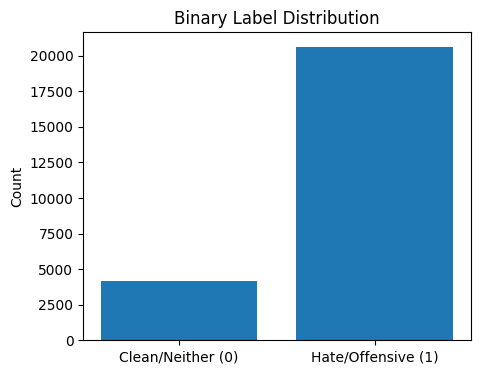

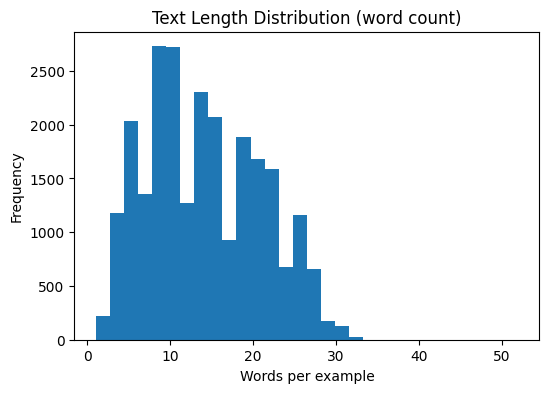

,word_count
count,24783.000000
mean,14.117016
std,6.825525
min,1.000000
25%,9.000000
50%,13.000000
75%,19.000000
max,52.000000


In [4]:
# ============================================================
# Cell 5: Exploratory Data Analysis (EDA)
# ============================================================
# EDA helps justify modeling choices in your report.

# 5.1 Label distribution plot
counts = df["label"].value_counts().sort_index()
plt.figure(figsize=(5,4))
plt.bar(["Clean/Neither (0)", "Hate/Offensive (1)"], counts.values)
plt.title("Binary Label Distribution")
plt.ylabel("Count")
plt.show()

# 5.2 Text length distribution (word count)
df["word_count"] = df["text"].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
plt.hist(df["word_count"], bins=30)
plt.title("Text Length Distribution (word count)")
plt.xlabel("Words per example")
plt.ylabel("Frequency")
plt.show()

display(df["word_count"].describe())


In [5]:
# ============================================================
# Cell 6: Stratified Train/Val/Test split
# ============================================================
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    stratify=df["label"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=SEED,
    stratify=temp_df["label"]
)

print("Train size:", len(train_df))
print("Val size:  ", len(val_df))
print("Test size: ", len(test_df))


Train size: 19826
Val size:   2478
Test size:  2479


In [6]:
# ============================================================
# Cell 7: Baseline model (required comparison)
# TF-IDF + Logistic Regression
# ============================================================
X_train_text = train_df["text"].tolist()
y_train = train_df["label"].values

X_test_text = test_df["text"].tolist()
y_test = test_df["label"].values

# TF-IDF: strong baseline for text classification
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)

baseline = LogisticRegression(max_iter=1000)
baseline.fit(X_train_tfidf, y_train)

baseline_preds = baseline.predict(X_test_tfidf)

print("=== BASELINE (TF-IDF + Logistic Regression) ===")
print(classification_report(y_test, baseline_preds, target_names=["Clean (0)", "Hate/Offensive (1)"]))


=== BASELINE (TF-IDF + Logistic Regression) ===
                    precision    recall  f1-score   support

         Clean (0)       0.91      0.64      0.75       417
Hate/Offensive (1)       0.93      0.99      0.96      2062

          accuracy                           0.93      2479
         macro avg       0.92      0.81      0.85      2479
      weighted avg       0.93      0.93      0.92      2479



In [7]:
# ============================================================
# Cell 8: Architecture pipeline diagram + hyperparameters
# (Useful for your report "Model architecture" rubric)
# ============================================================
print("""
PIPELINE DIAGRAM (BERT Fine-Tuning)
-----------------------------------
Raw text
  ↓
BERT Tokenizer (WordPiece)
  ↓
input_ids + attention_mask (padded/truncated)
  ↓
BERT Encoder (12 layers, self-attention)
  ↓
[CLS] pooled representation
  ↓
Linear classification head
  ↓
Softmax → Predicted class (0/1)
""")

hyperparams = pd.DataFrame([{
    "Model": "bert-base-uncased",
    "Max length": 128,
    "Batch size": 16,
    "Epochs": 3,
    "Learning rate": 2e-5,
    "Optimizer": "AdamW",
    "Scheduler": "Linear warmup (10%)",
    "Task": "Binary classification"
}])

display(hyperparams)



PIPELINE DIAGRAM (BERT Fine-Tuning)
-----------------------------------
Raw text
  ↓
BERT Tokenizer (WordPiece)
  ↓
input_ids + attention_mask (padded/truncated)
  ↓
BERT Encoder (12 layers, self-attention)
  ↓
[CLS] pooled representation
  ↓
Linear classification head
  ↓
Softmax → Predicted class (0/1)



,Model,Max length,Batch size,Epochs,Learning rate,Optimizer,Scheduler,Task
0,bert-base-uncased,128,16,3,0.00002,AdamW,Linear warmup (10%),Binary classification


In [8]:
# ============================================================
# Cell 9: Tokenizer + PyTorch Dataset (reusable code structure)
# ============================================================
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 128  # short texts; efficient and justified by length histogram

class TextDataset(Dataset):
    """
    A reusable Dataset class that:
    - tokenizes text on-the-fly
    - returns tensors for BERT training
    """
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
# ============================================================
# Cell 10: DataLoaders (batching + shuffling)
# ============================================================
BATCH_SIZE = 16

train_ds = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer, MAX_LEN)
val_ds   = TextDataset(val_df["text"].tolist(),   val_df["label"].tolist(),   tokenizer, MAX_LEN)
test_ds  = TextDataset(test_df["text"].tolist(),  test_df["label"].tolist(),  tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:  ", len(val_loader))
print("Test batches: ", len(test_loader))


Train batches: 1240
Val batches:   155
Test batches:  155


In [10]:
# ============================================================
# Cell 11: Load pre-trained BERT for sequence classification
# ============================================================
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
).to(device)

print("Loaded model:", MODEL_NAME)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded model: bert-base-uncased


In [11]:
# ============================================================
# Cell 12: Metric functions (accuracy/precision/recall/F1)
# ============================================================
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=1
    )
    return acc, prec, rec, f1

@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    all_true, all_pred = [], []

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())

    acc, prec, rec, f1 = compute_metrics(all_true, all_pred)
    return acc, prec, rec, f1, np.array(all_true), np.array(all_pred)


In [12]:
# ============================================================
# Cell 13: Training loop (explicit PyTorch training)
# ============================================================
from torch.optim import AdamW

def train_one_epoch(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Passing labels makes the model compute cross-entropy loss internally
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # stability
        optimizer.step()
        scheduler.step()

    return total_loss / len(dataloader)


In [13]:
# ============================================================
# Cell 14: Fine-tune BERT (AdamW + scheduler)
# ============================================================
EPOCHS = 3
LR = 2e-5

optimizer = AdamW(model.parameters(), lr=LR)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

history = {"train_loss": [], "val_acc": [], "val_f1": []}

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler)
    val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train loss : {train_loss:.4f}")
    print(f"Val Acc    : {val_acc:.4f}")
    print(f"Val Prec   : {val_prec:.4f}")
    print(f"Val Recall : {val_rec:.4f}")
    print(f"Val F1     : {val_f1:.4f}")



Epoch 1/3
Train loss : 0.1777
Val Acc    : 0.9580
Val Prec   : 0.9725
Val Recall : 0.9772
Val F1     : 0.9748

Epoch 2/3
Train loss : 0.0868
Val Acc    : 0.9645
Val Prec   : 0.9833
Val Recall : 0.9738
Val F1     : 0.9786

Epoch 3/3
Train loss : 0.0507
Val Acc    : 0.9641
Val Prec   : 0.9787
Val Recall : 0.9782
Val F1     : 0.9784



=== BERT TEST RESULTS ===
Accuracy  : 0.9718
Precision : 0.9826
Recall    : 0.9835
F1-score  : 0.9830

Classification Report:
                    precision    recall  f1-score   support

         Clean (0)       0.92      0.91      0.92       417
Hate/Offensive (1)       0.98      0.98      0.98      2062

          accuracy                           0.97      2479
         macro avg       0.95      0.95      0.95      2479
      weighted avg       0.97      0.97      0.97      2479


Confusion Matrix:
 [[ 381   36]
 [  34 2028]]


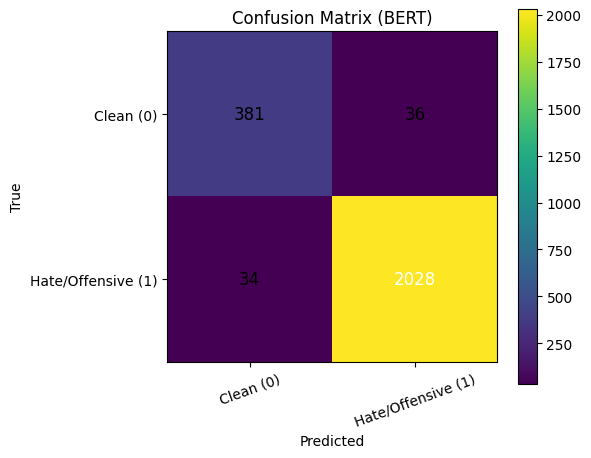

In [14]:
# ============================================================
# Cell 15: Final evaluation (test set) + readable confusion matrix
# ============================================================
test_acc, test_prec, test_rec, test_f1, y_true, y_pred = evaluate(model, test_loader)

print("\n=== BERT TEST RESULTS ===")
print(f"Accuracy  : {test_acc:.4f}")
print(f"Precision : {test_prec:.4f}")
print(f"Recall    : {test_rec:.4f}")
print(f"F1-score  : {test_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Clean (0)", "Hate/Offensive (1)"]))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

labels = ["Clean (0)", "Hate/Offensive (1)"]

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix (BERT)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], labels, rotation=20)
plt.yticks([0,1], labels)
plt.colorbar()

threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, f"{cm[i, j]}",
            ha="center", va="center",
            color="white" if cm[i, j] > threshold else "black",
            fontsize=12
        )

plt.tight_layout()
plt.show()


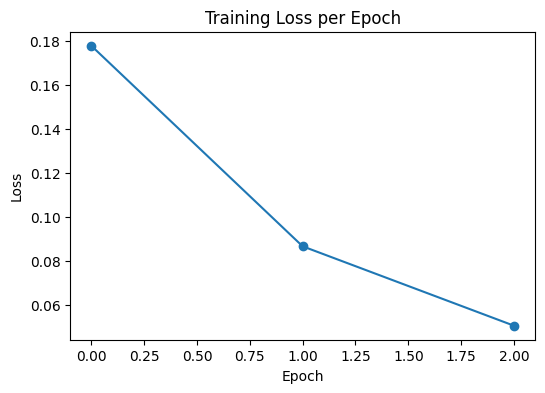

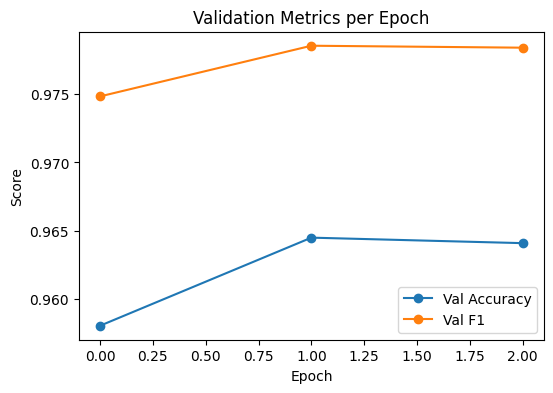

In [15]:
# ============================================================
# Cell 16: Plot training curves
# ============================================================
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], marker="o")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["val_acc"], marker="o", label="Val Accuracy")
plt.plot(history["val_f1"], marker="o", label="Val F1")
plt.title("Validation Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()


In [16]:
# ============================================================
# Cell 17: Comparison table (baseline vs BERT)
# ============================================================
base_acc = accuracy_score(y_test, baseline_preds)
base_prec, base_rec, base_f1, _ = precision_recall_fscore_support(
    y_test, baseline_preds, average="binary", pos_label=1
)

results = pd.DataFrame([
    {"Model": "TF-IDF + Logistic Regression", "Accuracy": base_acc, "Precision": base_prec, "Recall": base_rec, "F1": base_f1},
    {"Model": "Fine-tuned BERT (bert-base-uncased)", "Accuracy": test_acc, "Precision": test_prec, "Recall": test_rec, "F1": test_f1},
])

display(results)


,Model,Accuracy,Precision,Recall,F1
0,TF-IDF + Logistic Regression,0.928600,0.930562,0.987876,0.958363
1,Fine-tuned BERT (bert-base-uncased),0.971763,0.982558,0.983511,0.983034
